In [1]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers import AutoProcessor, WhisperForAudioClassification, AutoConfig, PreTrainedModel, WhisperModel
from transformers import WhisperFeatureExtractor
from transformers import WhisperProcessor
import librosa
import torch
from tqdm.auto import tqdm
import torch.nn.functional as F
from datasets import load_dataset, concatenate_datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import time
import random
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
from dataclasses import dataclass
from typing import List, Dict, Union, List, Any

2025-06-16 11:05:05.134021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750071905.601721      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750071905.725966      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
torch.set_float32_matmul_precision("high")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Uses device: {device}")

# кастомная архитектура классификатора на базе whisper енкодера
class WhisperClassifier(nn.Module):
    def __init__(self, hidden_size, num_labels=5, dropout=0.2):
        super().__init__()
        self.pool_norm = nn.LayerNorm(hidden_size)
        self.pre_dropout = nn.Dropout(dropout)

        mid1 = max(hidden_size // 2, num_labels * 4)
        mid2 = max(hidden_size // 4, num_labels * 2)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, mid1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(mid1),
            nn.Linear(mid1, mid2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(mid2),
            nn.Linear(mid2, num_labels),
        )

    def forward(self, hidden_states, attention_mask=None):
        if attention_mask is not None:
            lengths = attention_mask.sum(dim=1, keepdim=True)
            masked = hidden_states * attention_mask.unsqueeze(-1)
            pooled = masked.sum(dim=1) / lengths
        else:
            pooled = hidden_states.mean(dim=1)
        x = self.pool_norm(pooled)
        x = self.pre_dropout(x)
        logits = self.classifier(x)
        return logits

class WhisperForEmotionClassification(PreTrainedModel):
    config_class = AutoConfig

    def __init__(
        self, config, model_name="openai/whisper-small", num_labels=5, dropout=0.2
    ):
        super().__init__(config)
        self.encoder = WhisperModel.from_pretrained(model_name).encoder
        hidden_size = config.hidden_size
        self.classifier = WhisperClassifier(
            hidden_size, num_labels=num_labels, dropout=dropout
        )
        self.post_init()

    def forward(self, input_features, attention_mask=None, labels=None):
        encoder_output = self.encoder(
            input_features=input_features,
            attention_mask=attention_mask,
            return_dict=True,
        )
        hidden_states = encoder_output.last_hidden_state
        logits = self.classifier(hidden_states, attention_mask=attention_mask)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(
                logits.view(-1, logits.size(-1)), labels.view(-1)
            )
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )
        
model_name = "nixiieee/whisper-small-emotion-classifier-dusha"
processor = WhisperProcessor.from_pretrained("openai/whisper-small", return_attention_mask=True)
config = AutoConfig.from_pretrained(model_name)
model = WhisperForEmotionClassification.from_pretrained(model_name, num_labels=5, dropout=0.2).to(device)

Uses device: cuda


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

In [4]:
model

WhisperForEmotionClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 768)
    (layers): ModuleList(
      (0-11): 12 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementw

In [5]:
ds = load_dataset("nixiieee/dusha_balanced", split='test')

README.md:   0%|          | 0.00/912 [00:00<?, ?B/s]

train-00000-of-00011.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

train-00001-of-00011.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

train-00002-of-00011.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

train-00003-of-00011.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

train-00004-of-00011.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00005-of-00011.parquet:   0%|          | 0.00/459M [00:00<?, ?B/s]

train-00006-of-00011.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00007-of-00011.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

train-00008-of-00011.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00009-of-00011.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00010-of-00011.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

val-00000-of-00002.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

val-00001-of-00002.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

test-00000-of-00002.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

test-00001-of-00002.parquet:   0%|          | 0.00/252M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/36868 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/3600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3601 [00:00<?, ? examples/s]

In [11]:
test_sample = ds[0]['audio']
test_label = ds[0]['emotion']
print(test_sample)
print(test_label)

{'path': 'c7ecb2e501e4bcf41b714cd93e720368.wav', 'array': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.83105469e-04, 6.10351562e-05, 1.22070312e-04]), 'sampling_rate': 16000}
0


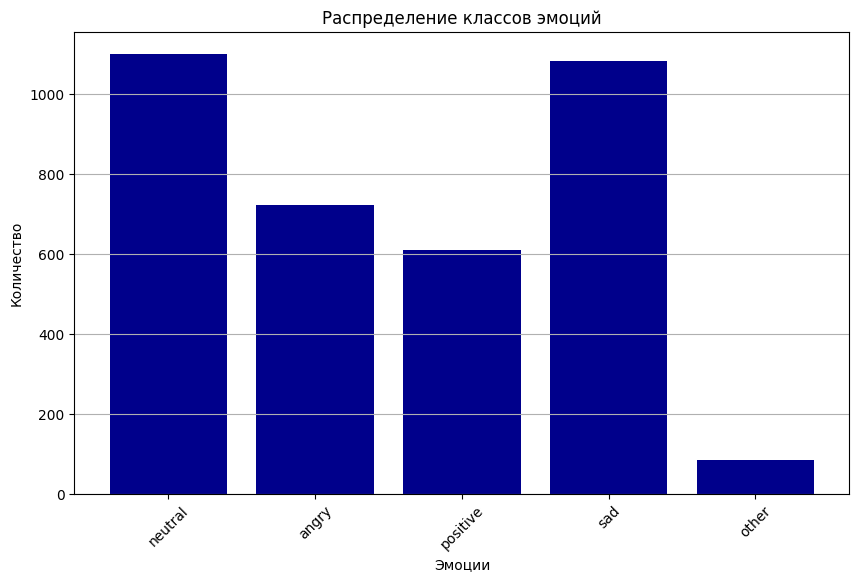

In [12]:
class_counts = Counter(ds['emotion'])

#label_mapping = {'neutral': 0, 'angry': 1, 'positive': 2, 'sad': 3, 'other': 4}
label_mapping = {0: "neutral", 1: "angry", 2: "positive", 3: "sad", 4: "other"}
# labels = list(label_mapping.keys())
# values = [class_counts[label] for label in labels]
labels = list(label_mapping.values())
values = [class_counts[key] for key in label_mapping.keys()]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='darkblue')
plt.title('Распределение классов эмоций')
plt.xlabel('Эмоции')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [6]:
@dataclass
class DataCollatorForEncoderClassification:
    processor: Any
    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_features = [
            {"input_features": feature["input_features"]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(
            input_features, return_tensors="pt"
        )

        batch["labels"] = torch.tensor(
            [feature["labels"] for feature in features], dtype=torch.long
        )

        return batch


def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_features"] = processor(
        audio["array"], sampling_rate=audio["sampling_rate"]
    ).input_features[0]
    batch["labels"] = batch["emotion"]
    return batch


test_ds = ds.map(
    prepare_dataset, remove_columns=["audio", "emotion"]
)

data_collator = DataCollatorForEncoderClassification(processor)

Map:   0%|          | 0/3601 [00:00<?, ? examples/s]

In [7]:
test_loader = DataLoader(
    test_ds,
    batch_size=1, # для теста на одном семпле
    shuffle=False,
    collate_fn=data_collator
)

In [9]:
batch = next(iter(test_loader))
batch

{'input_features': tensor([[[-1.1957, -1.1957,  0.0992,  ..., -1.1957, -1.1957, -1.1957],
         [-1.1957, -1.1957,  0.0437,  ..., -1.1957, -1.1957, -1.1957],
         [-1.1957, -1.1957, -0.0255,  ..., -1.1957, -1.1957, -1.1957],
         ...,
         [-1.1957, -1.1957, -0.7794,  ..., -1.1957, -1.1957, -1.1957],
         [-1.1957, -1.1957, -0.8642,  ..., -1.1957, -1.1957, -1.1957],
         [-1.1957, -1.1957, -0.8560,  ..., -1.1957, -1.1957, -1.1957]]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32), 'labels': tensor([0])}

In [10]:
samples = list(test_loader)
random_sample = random.choice(samples)
random_sample

{'input_features': tensor([[[-9.6891e-01, -7.9528e-01, -4.4520e-01,  ..., -9.6891e-01,
          -9.6891e-01, -9.6891e-01],
         [-9.6891e-01, -6.0590e-01, -2.8697e-01,  ..., -9.6891e-01,
          -9.6891e-01, -9.6891e-01],
         [-9.6891e-01, -4.3982e-01,  9.3919e-04,  ..., -9.6891e-01,
          -9.6891e-01, -9.6891e-01],
         ...,
         [-6.5662e-01,  1.0818e-01,  2.1990e-01,  ..., -9.6891e-01,
          -9.6891e-01, -9.6891e-01],
         [-7.4213e-01,  3.9376e-02,  1.7163e-01,  ..., -9.6891e-01,
          -9.6891e-01, -9.6891e-01],
         [-7.6176e-01, -4.8387e-02, -1.0151e-01,  ..., -9.6891e-01,
          -9.6891e-01, -9.6891e-01]]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32), 'labels': tensor([

In [11]:
random_sample['input_features'].shape

torch.Size([1, 80, 3000])

In [12]:
random_sample['attention_mask'].shape

torch.Size([1, 80])

In [13]:
print(torch.isnan(batch['input_features']).any()) 

tensor(False)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train() # включаем dropout (нет batchnorm слоёв)

WhisperForEmotionClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 768)
    (layers): ModuleList(
      (0-11): 12 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementw

Тест на одном семпле

In [27]:
mc_all_preds = []
mc_all_labels = []
mc_all_logits = []
mc_all_probs = []

#batch = next(iter(test_loader))  # тест на одном батче
batch = random.choice(samples)
print(batch["labels"])
with torch.no_grad():
    for _ in tqdm(range(50), desc="Processing batches"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_features=batch['input_features'])
        logits = outputs.logits  # (batch_size, num_labels)
        mc_all_logits.append(logits.cpu().numpy())
        probs = F.softmax(logits, dim=-1)  #(batch_size, num_labels)
        mc_all_probs.append(probs.cpu().numpy())
        preds = torch.argmax(logits, dim=-1)
        mc_all_preds.extend(preds.cpu().tolist())
        mc_all_labels.extend(batch['labels'].cpu().tolist())

tensor([3])


Processing batches:   0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
mc_all_preds

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [29]:
mc_all_logits

[array([[ 0.8350648, -1.1438097, -1.7998046,  4.912718 , -2.7948308]],
       dtype=float32),
 array([[ 0.22718504, -0.28203955, -1.2077969 ,  4.2792325 , -3.763537  ]],
       dtype=float32),
 array([[ 0.504468 , -0.8077437, -1.3239313,  4.3789215, -3.2279763]],
       dtype=float32),
 array([[-0.66489345, -1.32441   , -0.07913826,  3.7843392 , -3.826651  ]],
       dtype=float32),
 array([[ 1.299072  , -0.54413915, -1.2213385 ,  3.9083726 , -2.9030333 ]],
       dtype=float32),
 array([[ 0.09532417, -0.3376201 , -1.034434  ,  3.5713687 , -2.9613428 ]],
       dtype=float32),
 array([[-0.17563206, -1.0823941 , -1.2066823 ,  4.566825  , -3.66635   ]],
       dtype=float32),
 array([[-0.17646259, -1.044276  , -0.27325487,  4.250622  , -2.0746899 ]],
       dtype=float32),
 array([[ 0.31116554, -0.09602302, -1.0383142 ,  3.6396317 , -3.387989  ]],
       dtype=float32),
 array([[-0.39503184, -0.39501542,  0.32984748,  3.649568  , -4.0917983 ]],
       dtype=float32),
 array([[ 1.073355  

In [22]:
mc_all_probs

[array([[0.00729173, 0.9808473 , 0.00186933, 0.00827619, 0.00171549]],
       dtype=float32),
 array([[0.02612443, 0.9409747 , 0.0019886 , 0.02685044, 0.00406189]],
       dtype=float32),
 array([[4.1333362e-03, 9.8793632e-01, 6.6348412e-03, 8.0509990e-04,
         4.9038540e-04]], dtype=float32),
 array([[0.00774612, 0.9858226 , 0.0017441 , 0.00282254, 0.00186457]],
       dtype=float32),
 array([[0.01559991, 0.96964294, 0.00236217, 0.0069887 , 0.00540626]],
       dtype=float32),
 array([[0.01218619, 0.95813894, 0.00374069, 0.02188295, 0.00405114]],
       dtype=float32),
 array([[0.0039889 , 0.99036974, 0.00312454, 0.00135876, 0.00115801]],
       dtype=float32),
 array([[4.5181062e-02, 9.1802323e-01, 8.3973707e-04, 3.0652044e-02,
         5.3039296e-03]], dtype=float32),
 array([[0.00156688, 0.99353796, 0.0017852 , 0.00176921, 0.0013407 ]],
       dtype=float32),
 array([[4.3225298e-03, 9.9123389e-01, 2.9049793e-03, 9.2565658e-04,
         6.1291951e-04]], dtype=float32),
 array([[

In [10]:
all_true_labels = np.array(ds['emotion'])

In [18]:
all_true_labels

array([0, 3, 3, ..., 2, 3, 1])

In [9]:
def mc_dropout_predictions(model, data_loader, T=10):
    model.train()
    all_preds = []
    iteration_times = []

    with torch.no_grad():
        for t in tqdm(range(T), desc='MC Dropout итерации'):
            start_time = time.time()
            preds = []
            for x_batch in tqdm(data_loader, desc="Processing all batches"):
                batch = {k: v.to(device) for k, v in x_batch.items()}
                labels = batch['labels'].cpu().numpy()  # true labels для батча
                outputs = model(input_features=batch['input_features'])
                logits = outputs.logits
                # probs = F.softmax(logits, dim=-1).cpu().numpy()
                # probs_list.append(probs)
                y_pred = F.softmax(logits, dim=1)
                preds.append(y_pred.cpu().numpy())
            preds = np.vstack(preds)
            all_preds.append(preds)
            iteration_times.append(time.time() - start_time)
            print(f'Итерация {t+1}/{T} завершена за {iteration_times[-1]:.4f} секунд.')

    all_preds = np.array(all_preds)
    mean_preds = all_preds.mean(axis=0)
    print(f'Среднее время итерации: {np.mean(iteration_times):.4f} секунд.')
    return mean_preds, all_preds

In [15]:
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for x_batch in tqdm(data_loader, desc="Processing all batches"):
            batch = {k: v.to(device) for k, v in x_batch.items()}
            labels = batch['labels'].cpu().numpy()  # true labels для батча
            outputs = model(input_features=batch['input_features'])
            logits = outputs.logits
            #probs = F.softmax(logits, dim=-1).cpu().numpy()
            # probs_list.append(probs)
            y_pred = F.softmax(logits, dim=1)
            #label_pred = np.argmax(y_pred, axis=1)
            label_pred = torch.argmax(y_pred, dim=-1)
            all_preds.append(label_pred.cpu().numpy())
        # preds = np.vstack(preds)
        # all_preds.append(preds)

    all_preds = np.array(all_preds)
    # mean_preds = all_preds.mean(axis=0)
    # print(f'Среднее время итерации: {np.mean(iteration_times):.4f} секунд.')
    model.train()
    return all_preds

In [14]:
def get_probs(model, data_loader):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for x_batch in tqdm(data_loader, desc="Processing all batches"):
            batch = {k: v.to(device) for k, v in x_batch.items()}
            labels = batch['labels'].cpu().numpy()  # true labels для батча
            outputs = model(input_features=batch['input_features'])
            logits = outputs.logits
            probs = F.softmax(logits, dim=-1).cpu().numpy()
            # probs_list.append(probs)
            #y_pred = F.softmax(logits, dim=1)
            #label_pred = np.argmax(y_pred, axis=1)
            #label_pred = torch.argmax(y_pred, dim=-1)
            all_probs.append(probs)
        all_probs = np.vstack(all_probs)

    #all_probs = np.concatenate(all_probs) # [N, C]
    model.train()
    return all_probs

In [15]:
pred__test_probs = get_probs(model, test_loader)

Processing all batches:   0%|          | 0/3601 [00:00<?, ?it/s]

In [16]:
pred__test_probs.shape

(3601, 5)

In [21]:
pred__test_probs[0]

array([1.5983351e-01, 1.2124128e-02, 8.2041478e-01, 7.6090372e-03,
       1.8651424e-05], dtype=float32)

In [22]:
pred__test_probs.shape

(3601, 5)

In [88]:
test_loader = DataLoader(
    test_ds,
    batch_size=1, # для теста на одном семпле
    shuffle=False,
    collate_fn=data_collator
)

In [16]:
model.eval()
test_preds = get_predictions(model, test_loader)

Processing all batches:   0%|          | 0/3601 [00:00<?, ?it/s]

метрики без mc dropout

In [90]:
accuracy = accuracy_score(all_true_labels, test_preds)
balanced_accuracy = balanced_accuracy_score(all_true_labels, test_preds)
precision = precision_score(all_true_labels, test_preds, average='macro')
recall = recall_score(all_true_labels, test_preds, average='macro')
f1 = f1_score(all_true_labels, test_preds, average='macro')

print(f"acc: {accuracy:.4f}")
print(f"Balanced acc: {balanced_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

acc: 0.7473
Balanced acc: 0.7741
Precision: 0.7903
Recall: 0.7741
F1 Score: 0.7795


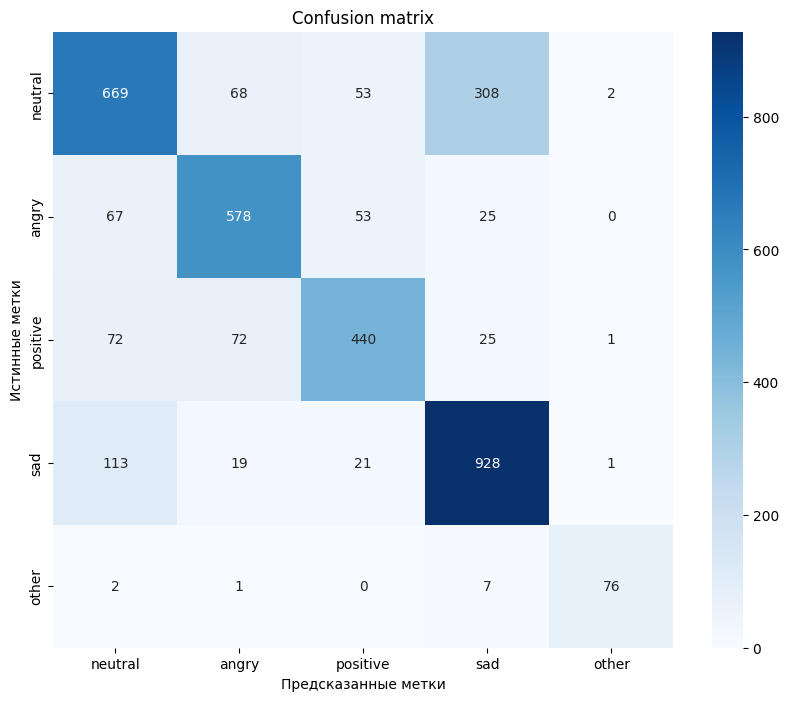

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_true_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.title('Confusion matrix')
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.show()

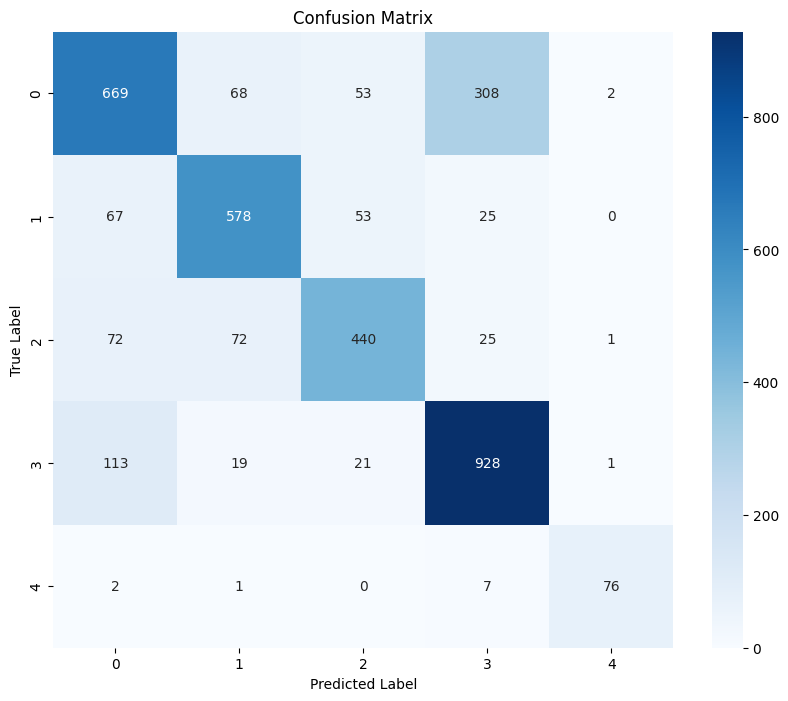

In [91]:
cm = confusion_matrix(all_true_labels, test_preds)
    
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [38]:
def evaluate_mean_preds(all_labels, all_preds):
    """
    all_labels: тензор размерности (T, N, C)
    all_preds: предсказания по усредненным вероятностям
    """
    mean_probs = np.mean(all_preds, axis=0)
    class_preds = np.argmax(mean_probs, axis=1)
    accuracy = accuracy_score(all_labels, class_preds)
    balanced_accuracy = balanced_accuracy_score(all_labels, class_preds)
    precision = precision_score(all_labels, class_preds, average='weighted')
    recall = recall_score(all_labels, class_preds, average='weighted')
    f1 = f1_score(all_labels, class_preds, average='weighted')
    
    print(f"acc: {accuracy:.4f}")
    print(f"Balanced acc: {balanced_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def evaluate_confusion_matrix(all_labels, all_preds):
    """
    all_labels: тензор размерности (T, N, C)
    all_preds: предсказания по усредненным вероятностям
    """
    mean_probs = np.mean(all_preds, axis=0)
    class_preds = np.argmax(mean_probs, axis=1)
    
    cm = confusion_matrix(all_labels, class_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return cm

In [42]:
def visualize_uncertainties(all_mc_preds, all_labels):
    class_preds = all_mc_preds.argmax(axis=2)
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis = 0, arr = class_preds)
    correct_with_mc = (final_predictions == all_labels).sum()
    accuracy_with_mc = correct_with_mc / len(all_labels) * 100

    print(f"Точность с MC Dropout: {accuracy_with_mc:.2f}%")
    
    uncertainties = np.var(class_preds, axis = 0)
    
    plt.figure(figsize = (10, 6))
    plt.hist(uncertainties, bins = 50, alpha = 0.75)
    plt.title("Распределение неопределенности предсказаний")
    plt.xlabel("Неопределенность (Дисперсия)")
    plt.ylabel("Частота")
    plt.xticks(np.arange(min(uncertainties), max(uncertainties), 1))
    plt.grid(True)
    plt.show()

In [35]:
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=data_collator
)

In [36]:
model.train()
mean_preds, all_preds = mc_dropout_predictions(model, test_loader)

MC Dropout итерации:   0%|          | 0/10 [00:00<?, ?it/s]

Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 1/10 завершена за 826.1602 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 2/10 завершена за 827.0514 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 3/10 завершена за 825.0921 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 4/10 завершена за 824.9804 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 5/10 завершена за 822.3058 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 6/10 завершена за 823.1655 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 7/10 завершена за 824.7002 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 8/10 завершена за 819.5765 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 9/10 завершена за 823.2146 секунд.


Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

Итерация 10/10 завершена за 818.7662 секунд.
Среднее время итерации: 823.5013 секунд.


In [39]:
evaluate_mean_preds(all_true_labels, all_preds)

acc: 0.7417
Balanced acc: 0.7672
Precision: 0.7416
Recall: 0.7417
F1 Score: 0.7399


In [40]:
all_preds.shape

(10, 3601, 5)

Точность с MC Dropout: 74.51%


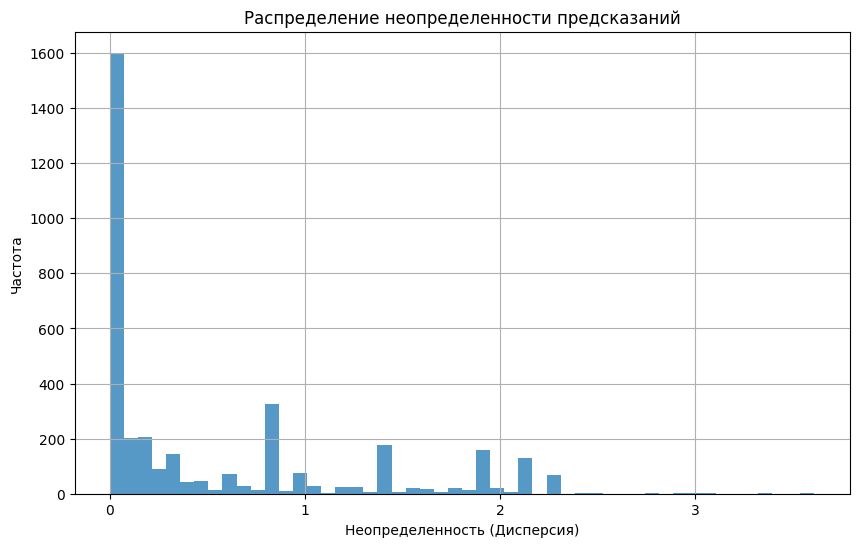

In [45]:
visualize_uncertainties(all_preds, all_true_labels)

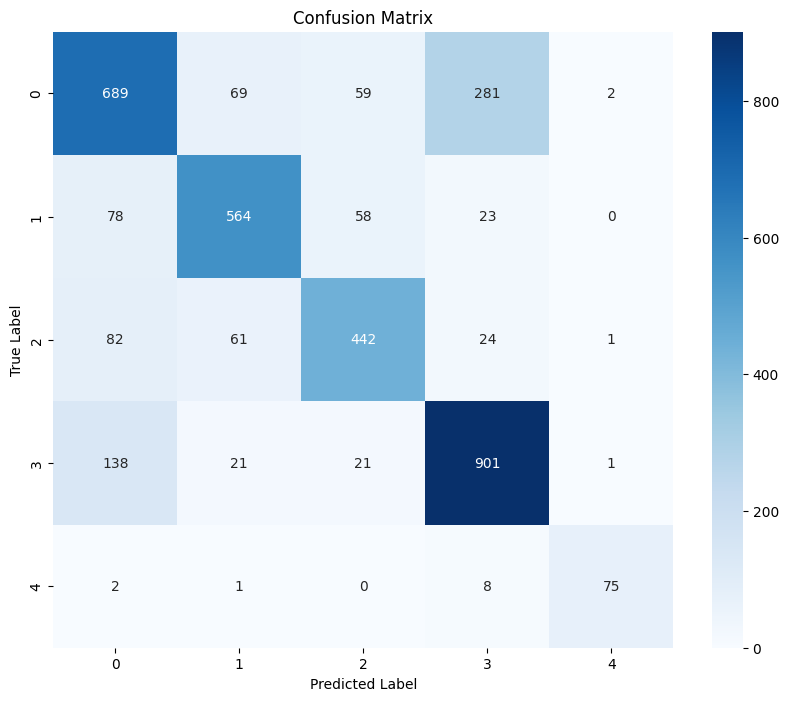

array([[689,  69,  59, 281,   2],
       [ 78, 564,  58,  23,   0],
       [ 82,  61, 442,  24,   1],
       [138,  21,  21, 901,   1],
       [  2,   1,   0,   8,  75]])

In [85]:
evaluate_confusion_matrix(all_true_labels, all_preds)

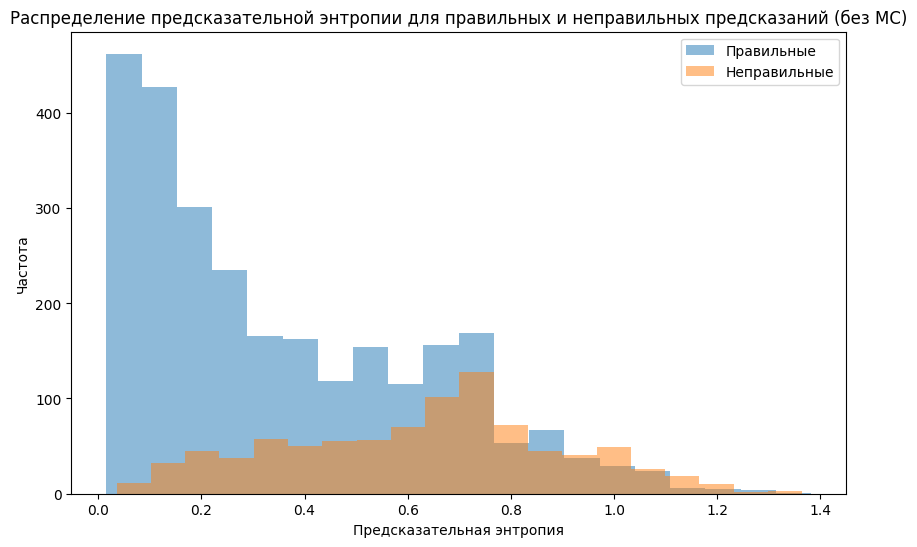

Класс 0: Средняя энтропия = 0.5144
Класс 1: Средняя энтропия = 0.3778
Класс 2: Средняя энтропия = 0.4464
Класс 3: Средняя энтропия = 0.3618
Класс 4: Средняя энтропия = 0.2163


In [30]:
def compute_predictive_entropy(all_preds):
    #mean_probs = np.mean(all_preds, axis=0)
    entropy = -np.sum(all_preds * np.log(all_preds + 1e-10), axis=1)
    return entropy

entropies = compute_predictive_entropy(pred__test_probs)
predicted_labels = np.argmax(pred__test_probs, axis=1)
correct = (predicted_labels == all_true_labels)

plt.figure(figsize=(10, 6))
plt.hist(entropies[correct], bins=20, alpha=0.5, label='Правильные')
plt.hist(entropies[~correct], bins=20, alpha=0.5, label='Неправильные')
plt.xlabel('Предсказательная энтропия')
plt.ylabel('Частота')
plt.title('Распределение предсказательной энтропии для правильных и неправильных предсказаний (без МС)')
plt.legend()
plt.show()

for class_idx in np.unique(all_true_labels):
    class_entropies = entropies[all_true_labels == class_idx]
    print(f'Класс {class_idx}: Средняя энтропия = {np.mean(class_entropies):.4f}')

In [ ]:
#для вероятностей без МС Dropout
def compute_predictive_entropy(all_preds):
    mean_probs = np.mean(all_preds, axis=0)
    entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-10), axis=1)
    return entropy

entropies = compute_predictive_entropy(all_preds)
predicted_labels = np.argmax(mean_preds, axis=1)
correct = (predicted_labels == all_true_labels)

plt.figure(figsize=(10, 6))
plt.hist(entropies[correct], bins=20, alpha=0.5, label='Правильные')
plt.hist(entropies[~correct], bins=20, alpha=0.5, label='Неправильные')
plt.xlabel('Предсказательная энтропия')
plt.ylabel('Частота')
plt.title('Распределение предсказательной энтропии для правильных и неправильных предсказаний')
plt.legend()
plt.show()

for class_idx in np.unique(all_true_labels):
    class_entropies = entropies[all_true_labels == class_idx]
    print(f'Класс {class_idx}: Средняя энтропия = {np.mean(class_entropies):.4f}')

In [55]:
# Рассмотрим средние значения вероятностей каждого класса
def analyze_aposterior_mean(mean_preds):
    sample_idx = random.randint(0, mean_preds.shape[0])
    print(f"Истинный класс: {all_true_labels[sample_idx]}")
    classes = [f'Класс {i}' for i in range(mean_preds.shape[1])]
    plt.figure(figsize=(10, 6))
    probs = mean_preds[sample_idx]
    bars = plt.bar(classes, probs, color='skyblue')
    plt.xlabel('Классы')
    plt.ylabel('Вероятность')
    plt.title('Вероятности классов для одного семпла')
    plt.ylim(0, 1)
    
    # подписи вероятностей над столбиками
    for bar, prob in zip(bars, probs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{prob:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Истинный класс: 1


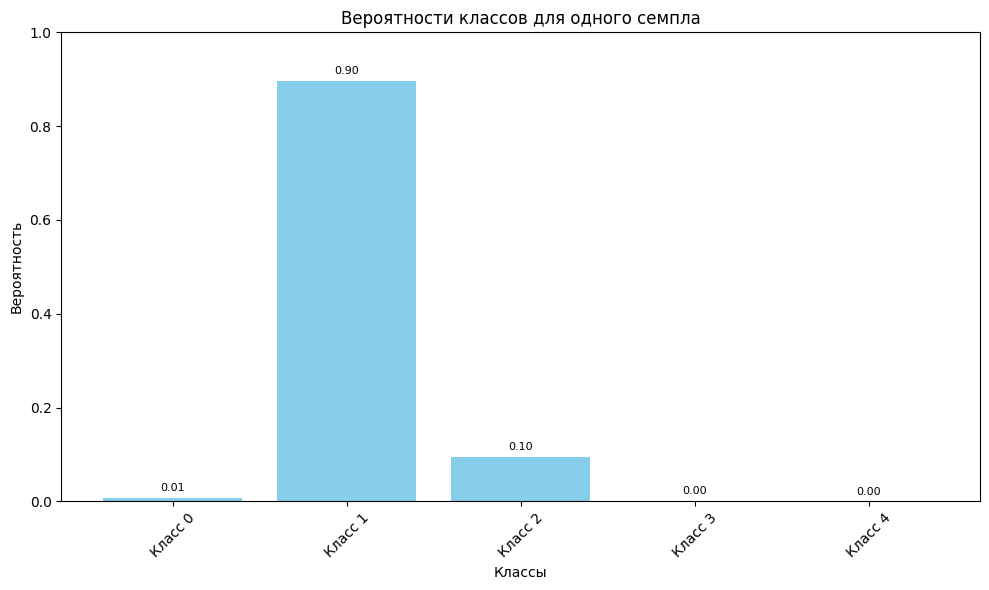

Истинный класс: 0


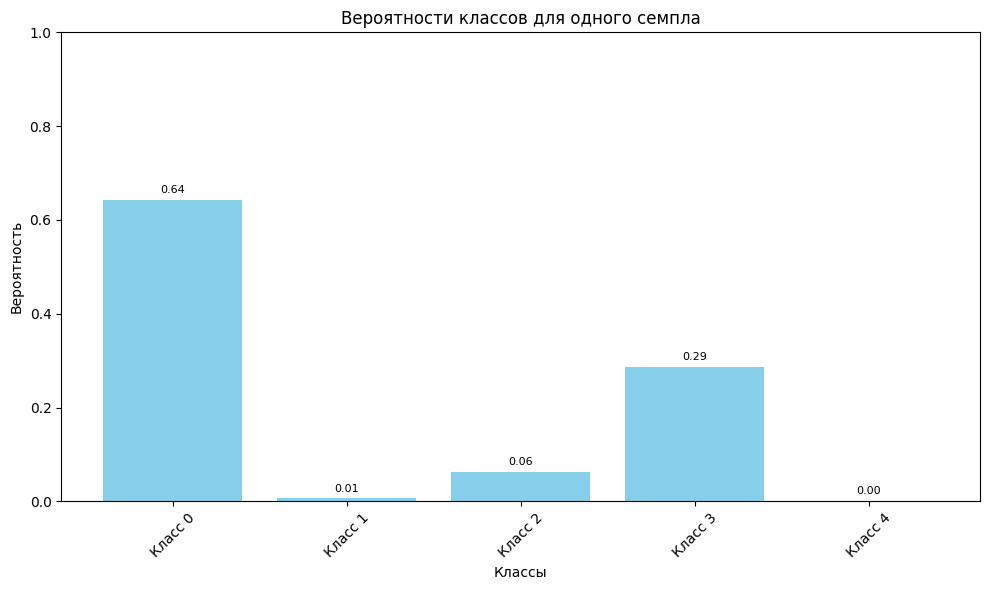

Истинный класс: 3


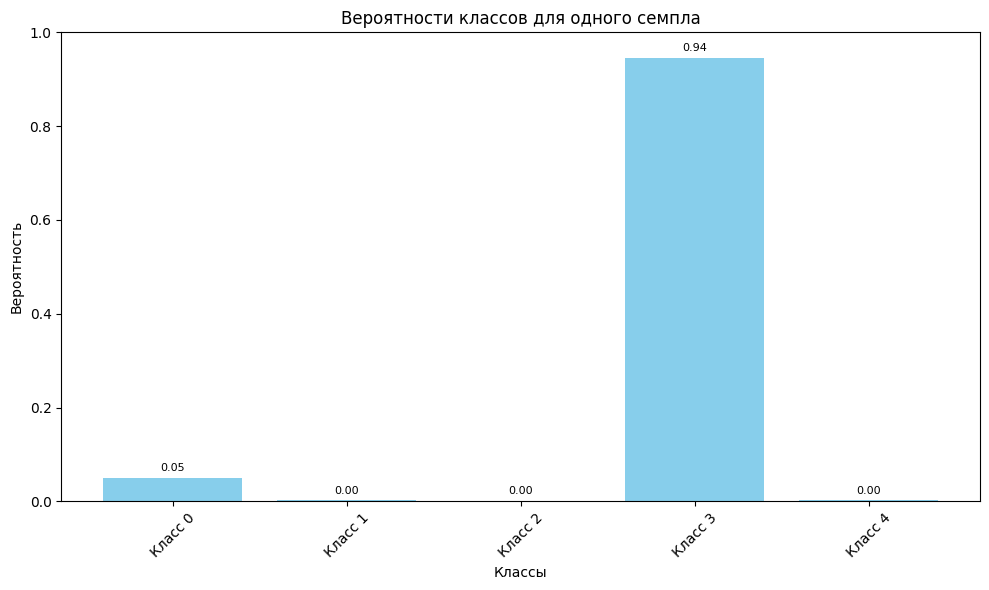

Истинный класс: 1


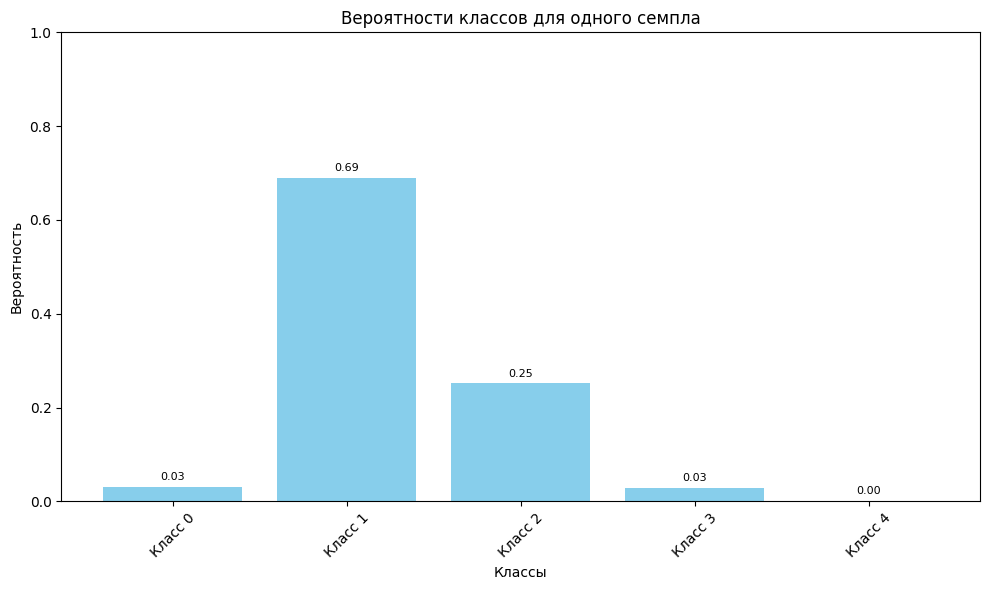

Истинный класс: 1


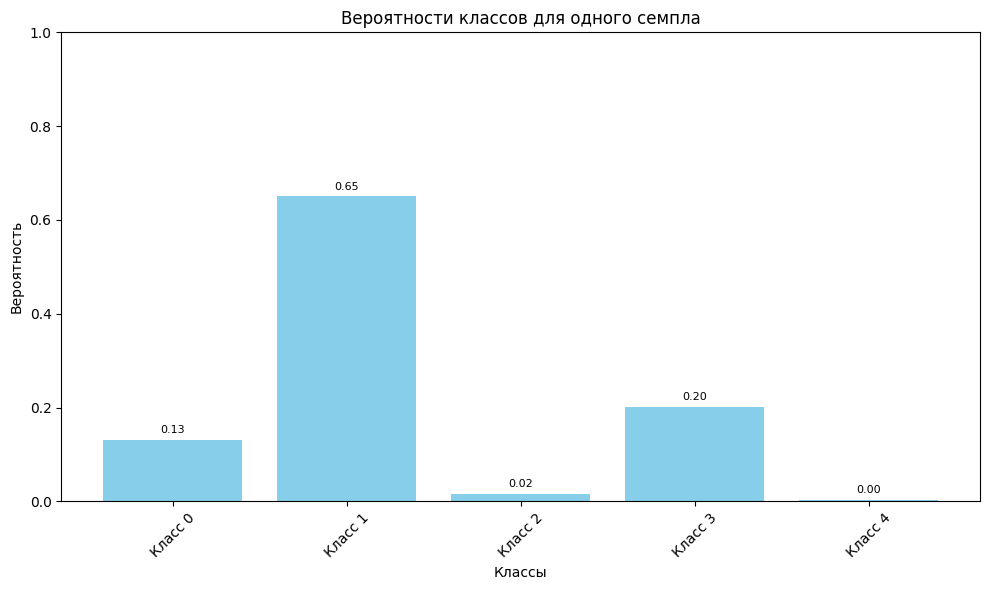

Истинный класс: 1


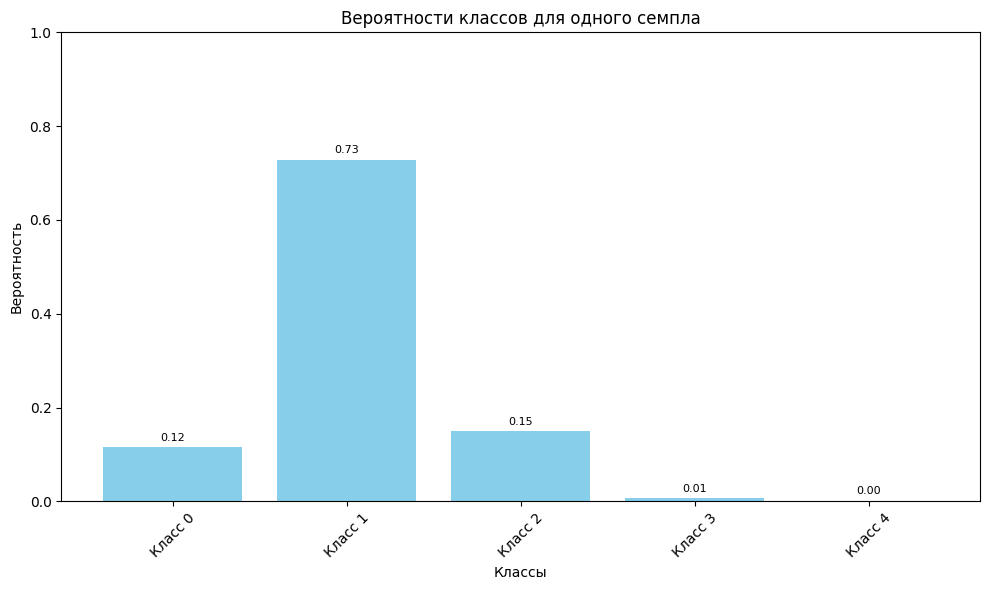

Истинный класс: 0


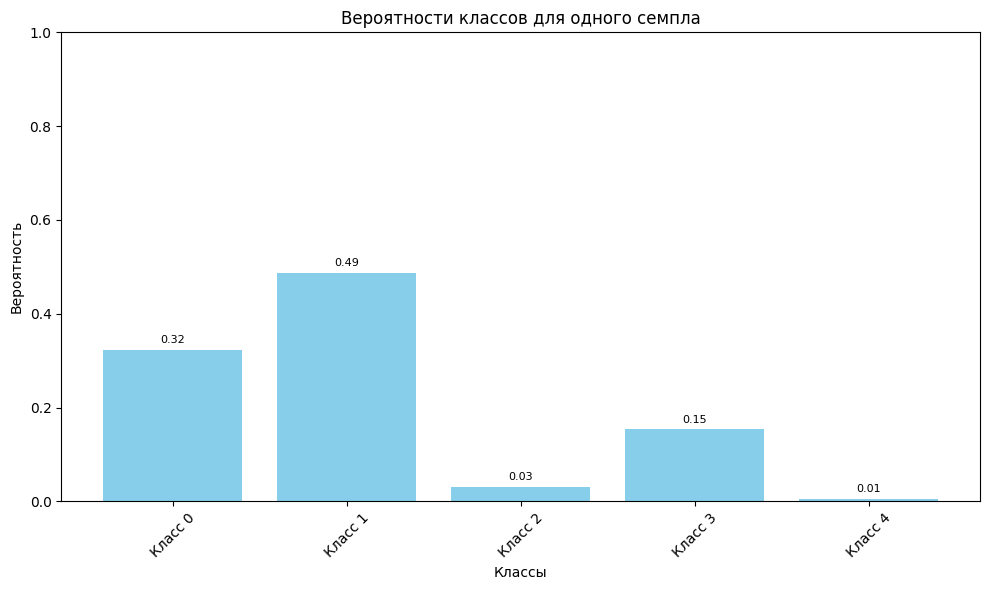

Истинный класс: 2


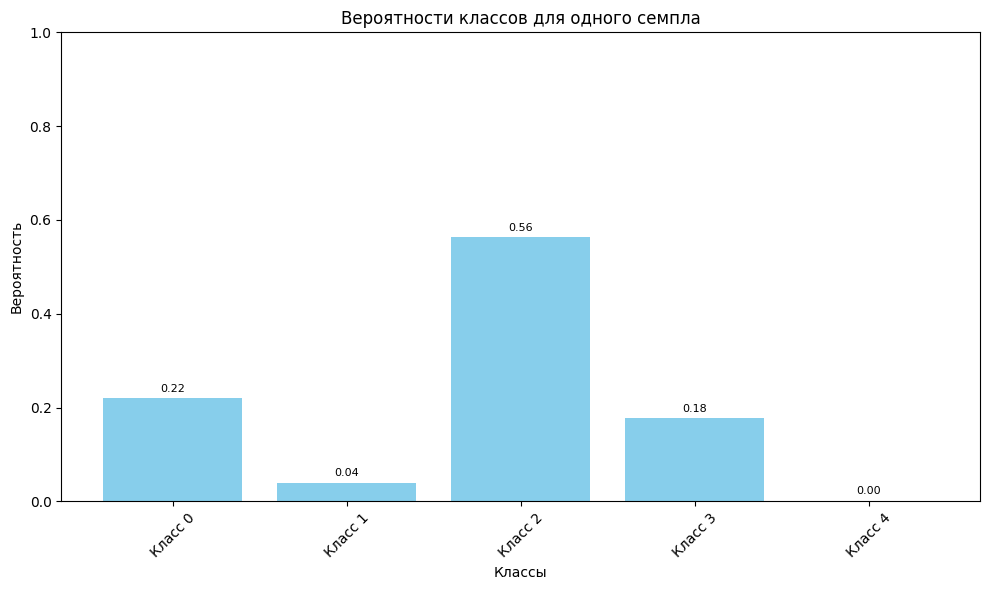

Истинный класс: 0


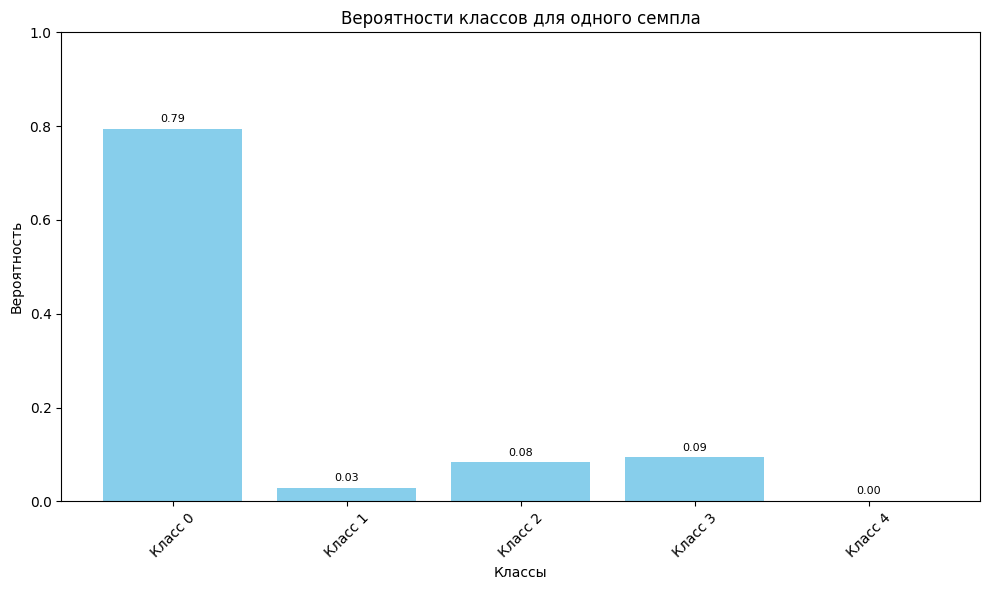

Истинный класс: 1


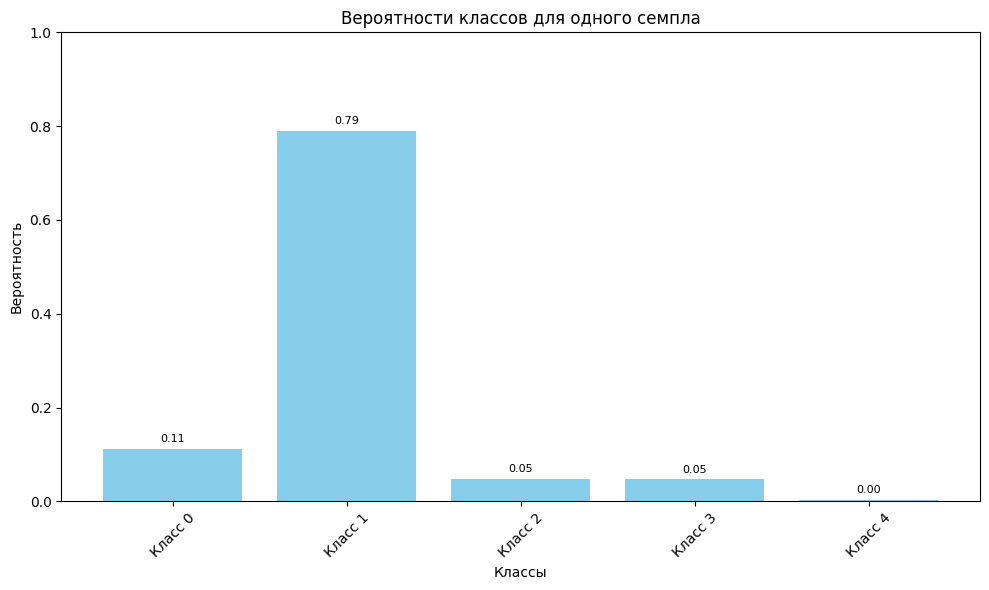

Истинный класс: 3


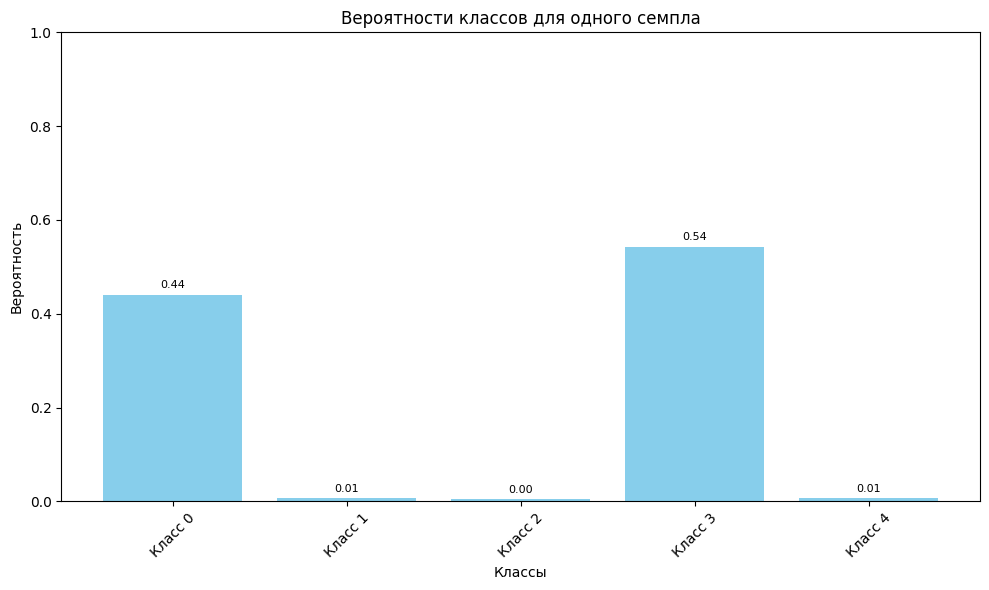

Истинный класс: 1


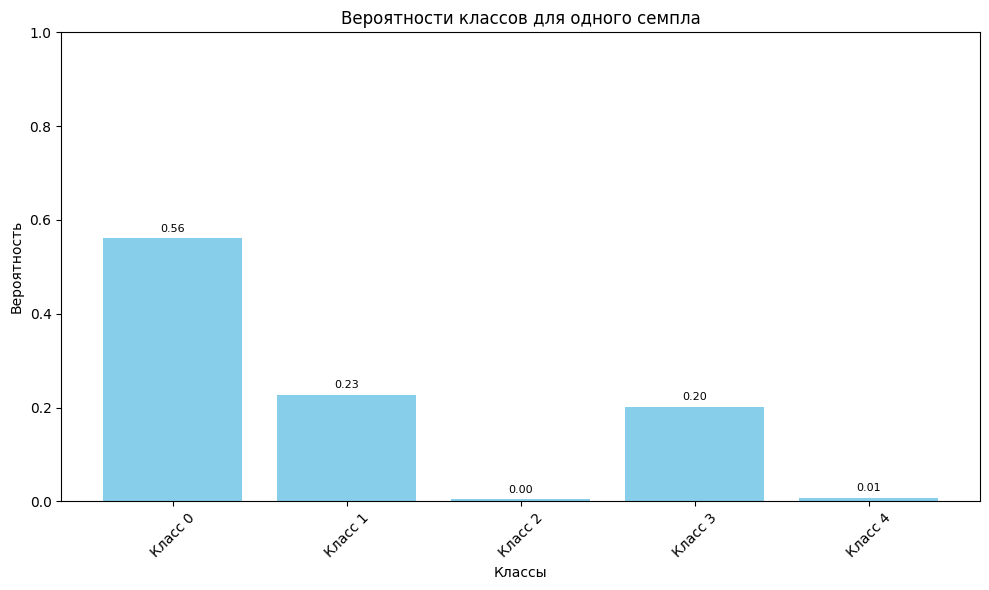

Истинный класс: 2


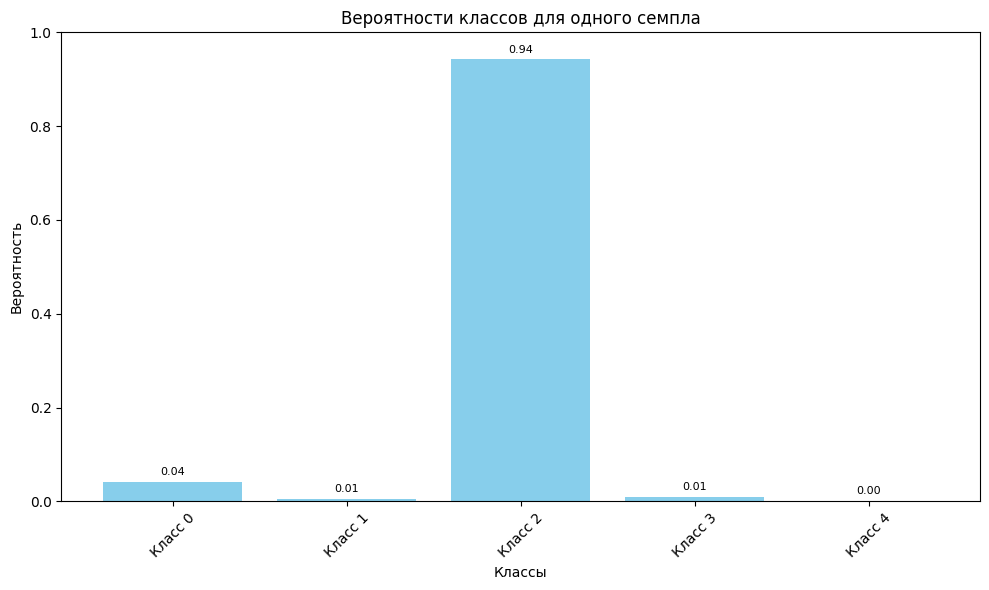

Истинный класс: 3


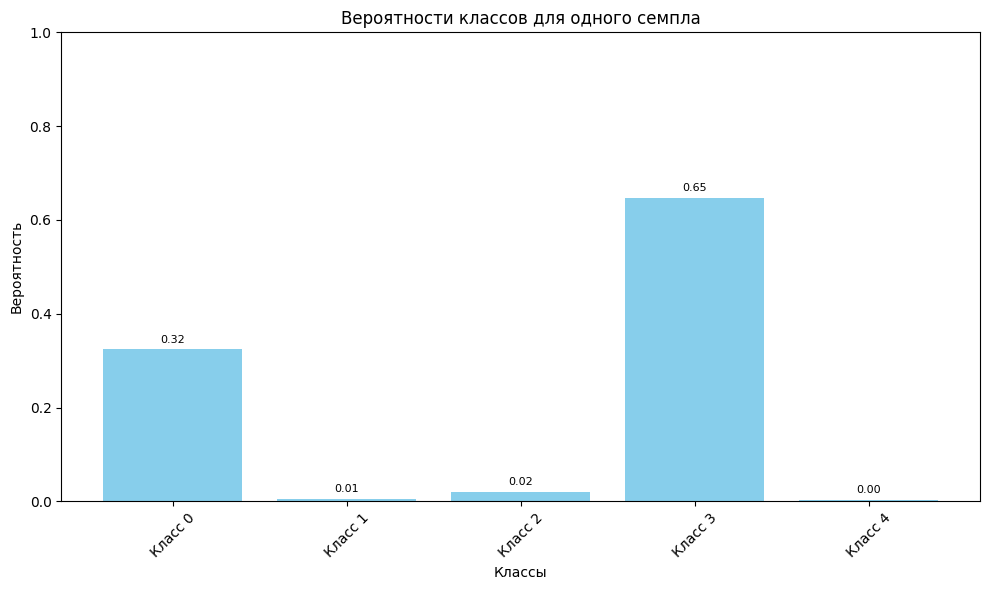

Истинный класс: 0


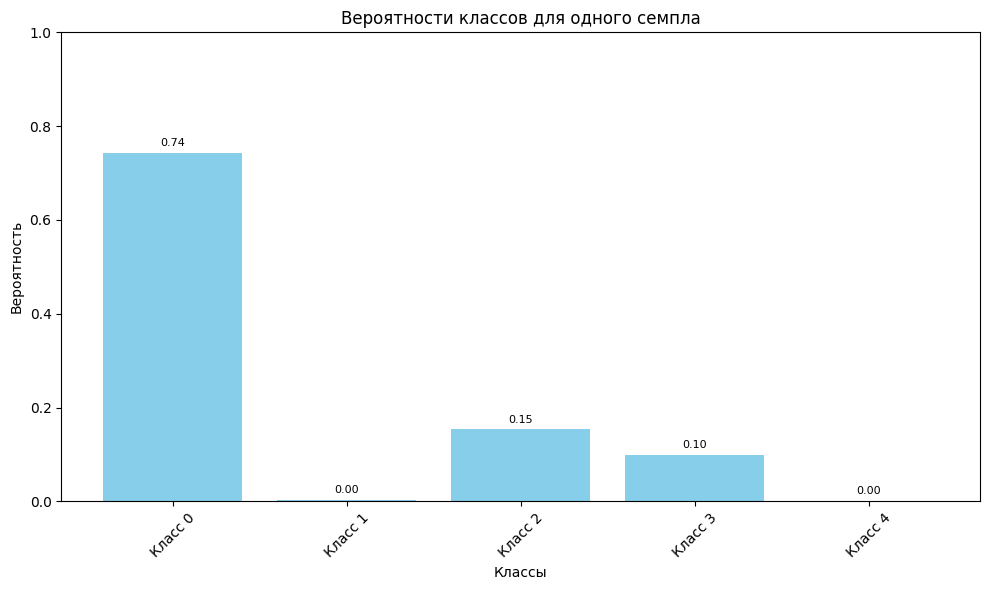

Истинный класс: 2


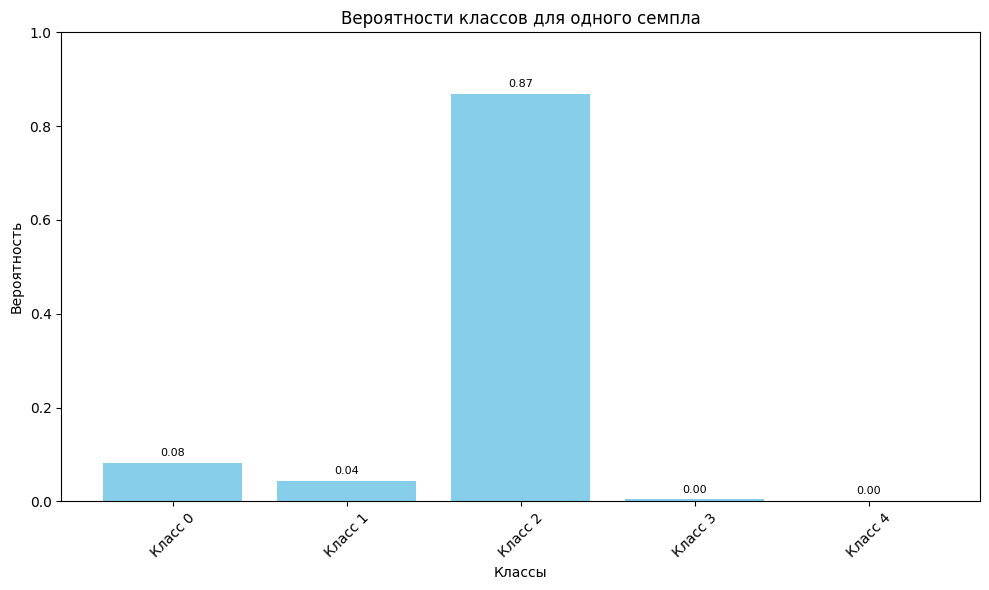

Истинный класс: 3


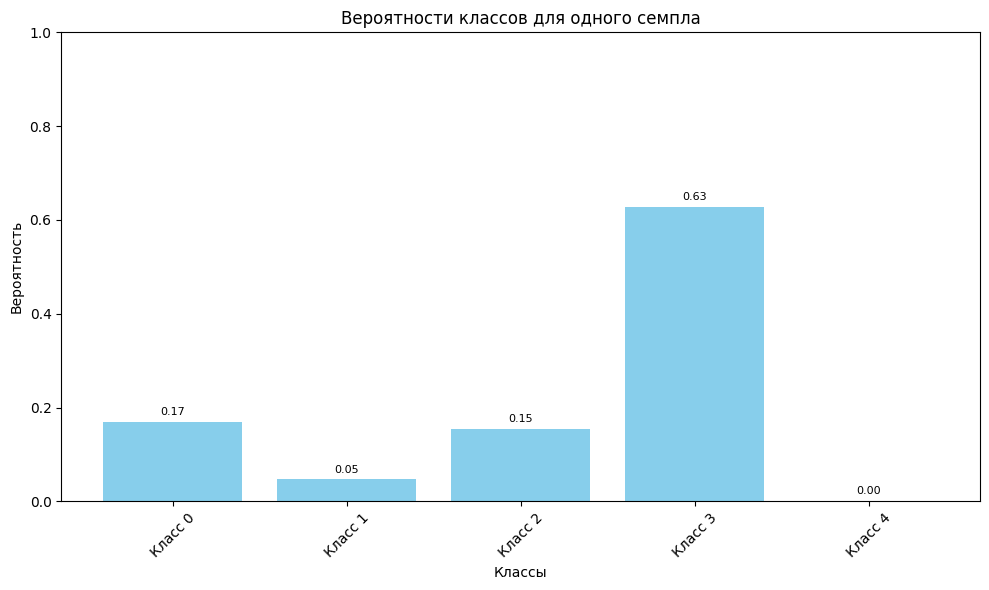

Истинный класс: 3


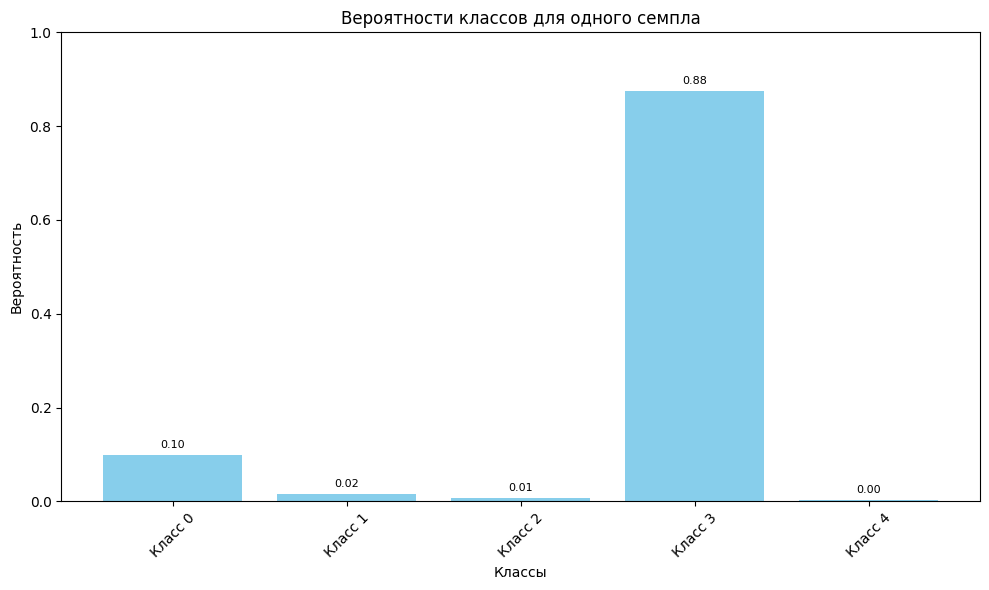

Истинный класс: 1


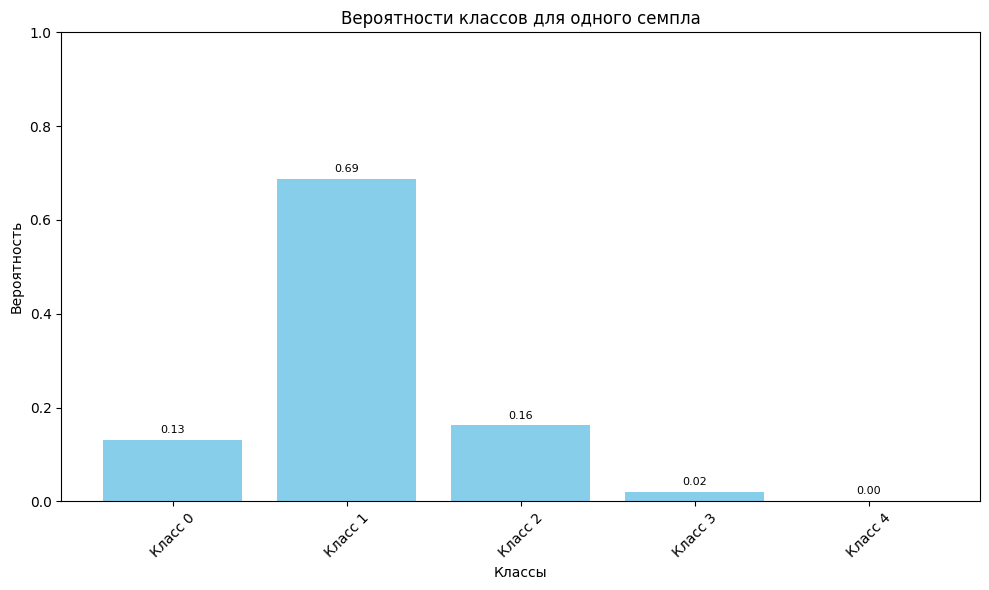

Истинный класс: 0


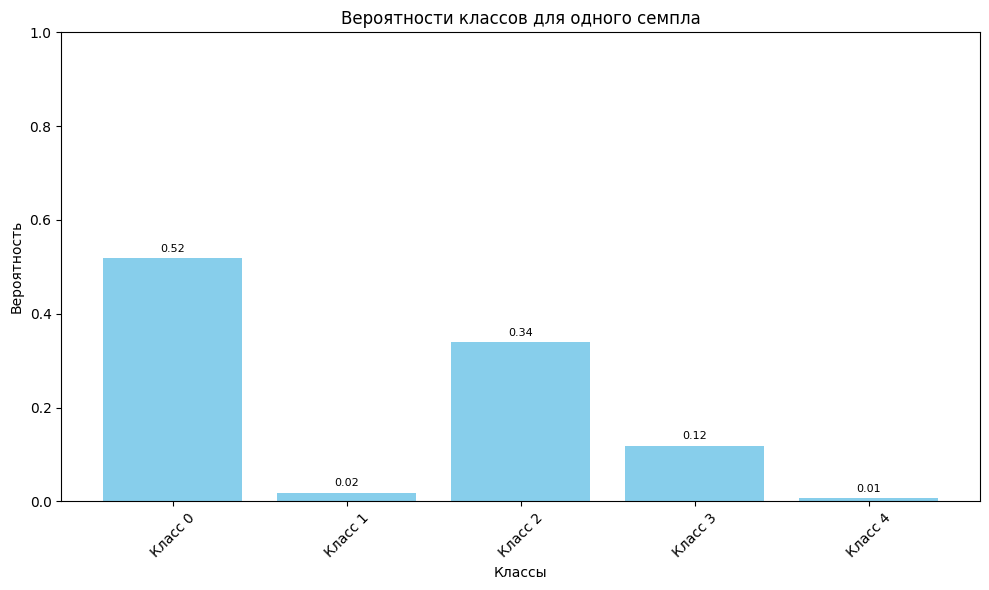

In [75]:
for _ in range(20):
    analyze_aposterior_mean(mean_preds)

In [76]:
# Рассмотрим распределения T вероятностей для одного сэмпла
def analyze_aposterior(all_mc_preds):
    sample_idx = random.randint(0, all_mc_preds.shape[1])
    print(f"Истинный класс: {all_true_labels[sample_idx]}")
    for class_idx in range(len(np.unique(all_true_labels))): 
        probs_for_class = all_mc_preds[:, sample_idx, class_idx]  # т.е. T значений вероятности для каждого класса
        
        plt.hist(probs_for_class, bins=10, alpha=0.7)
        plt.title(f'Гистограмма вероятностей для сэмпла {sample_idx}, класса {class_idx}')
        plt.xlabel('Вероятность')
        plt.ylabel('Частота')
        plt.show()

Истинный класс: 2


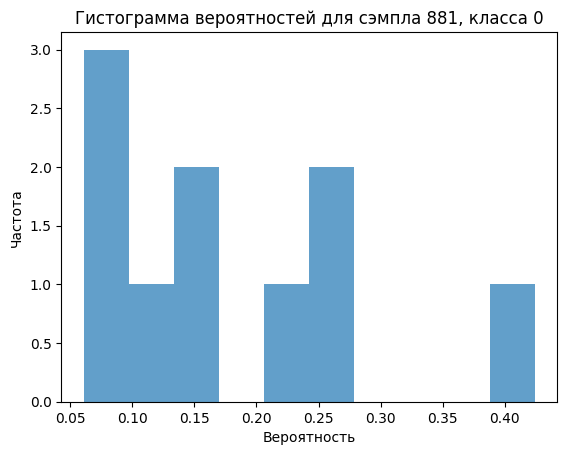

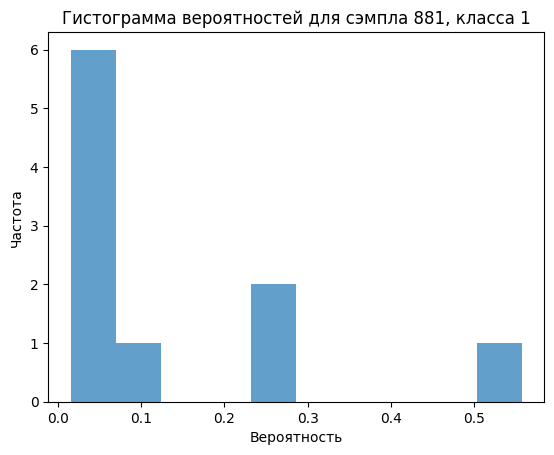

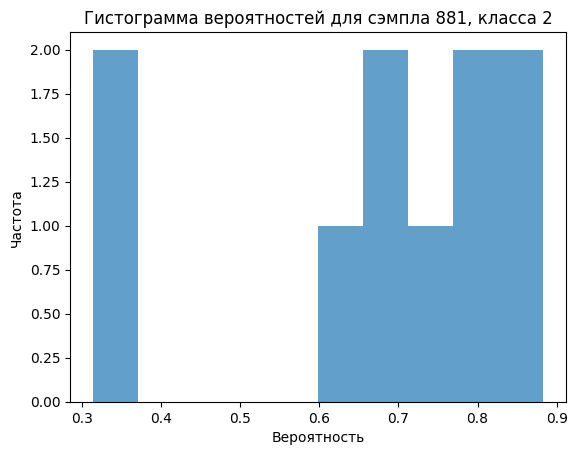

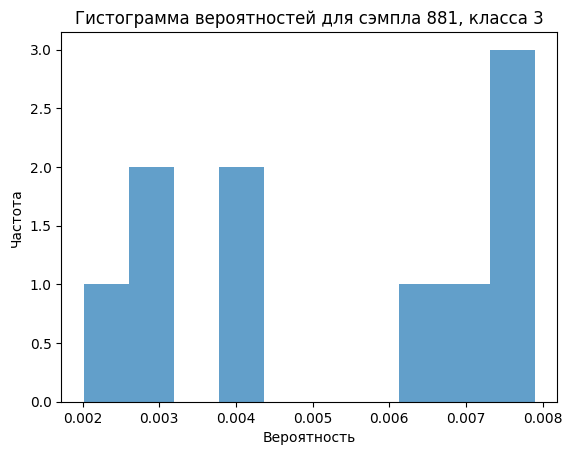

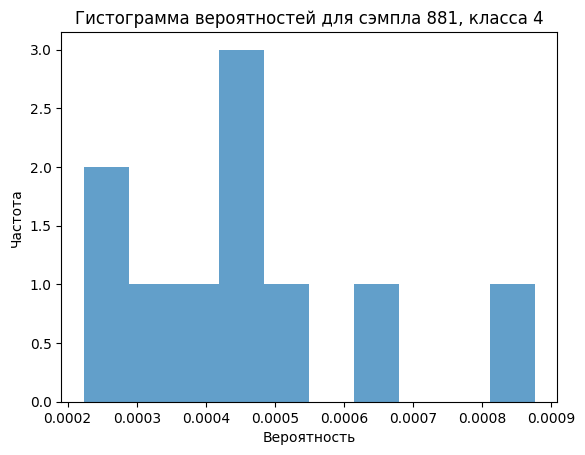

In [77]:
analyze_aposterior(all_preds)

In [81]:
np.save('all_preds_mc_10_iterations.npy', all_preds)

In [33]:
mc_preds = np.load('/kaggle/input/mc-preds/all_preds_mc_10_iterations.npy')
mc_preds.shape

(10, 3601, 5)

In [61]:
# анализ для МС и для обычных вероятностей
label_mapping = {0: "neutral", 1: "angry", 2: "positive", 3: "sad", 4: "other"}
def analyze_aposterior_mean(mc_preds, eval_preds):
    mean_preds = np.mean(mc_preds, axis=0)
    sample_idx = random.randint(0, mean_preds.shape[0] - 1)
    class_idx = all_true_labels[sample_idx]
    class_name = label_mapping[class_idx]
    print(f"Истинный класс: {class_name}")
    n_classes = mean_preds.shape[1]
    classes = [f'{label_mapping[i]}' for i in range(n_classes)]
    plt.figure(figsize=(8, 6))
    x = np.arange(n_classes)
    width = 0.35
    mean_probs = mean_preds[sample_idx]
    eval_probs = eval_preds[sample_idx]
    bars1 = plt.bar(x - width/2, mean_probs, width, color='skyblue', label='MC Dropout Mean')
    bars2 = plt.bar(x + width/2, eval_probs, width, color='blue', label='Model Eval')
    for bars, probs in [(bars1, mean_probs), (bars2, eval_probs)]:
        for bar, prob in zip(bars, probs):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{prob:.2f}', ha='center', va='bottom', fontsize=8)
    plt.xlabel('Классы')
    plt.ylabel('Вероятность')
    plt.title('Вероятности классов для одного семпла')
    plt.ylim(0, 1)
    plt.xticks(x, classes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()



Истинный класс: angry


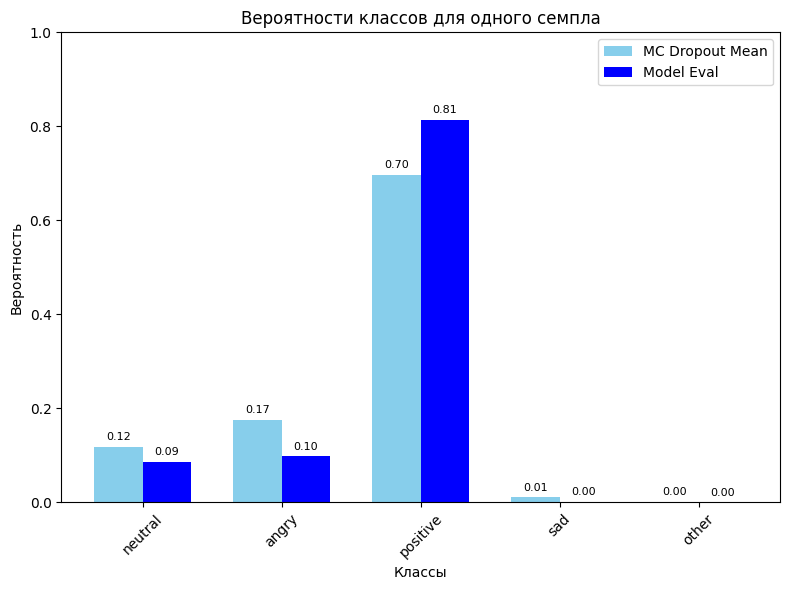

Истинный класс: angry


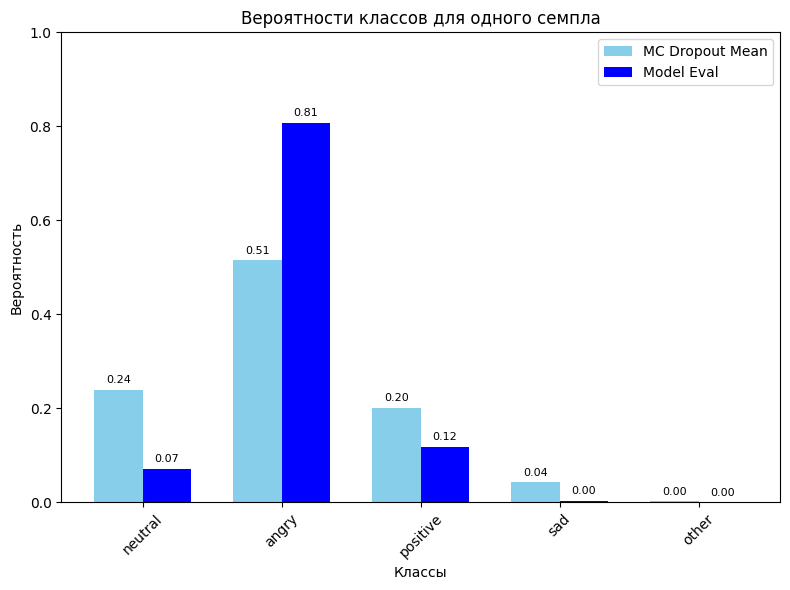

Истинный класс: sad


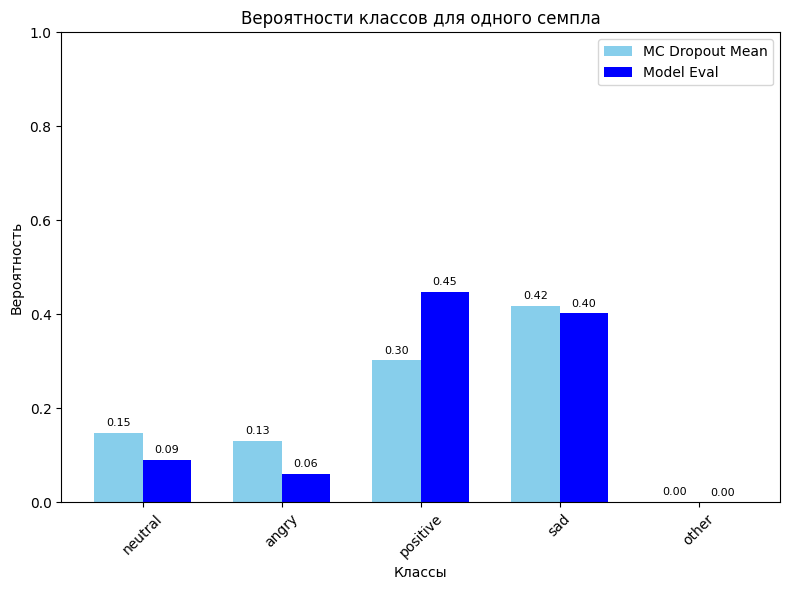

Истинный класс: neutral


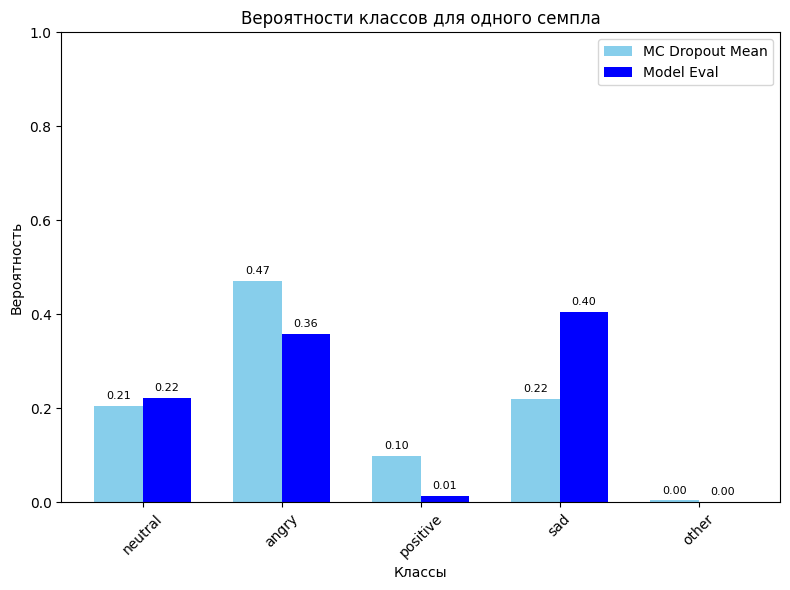

Истинный класс: angry


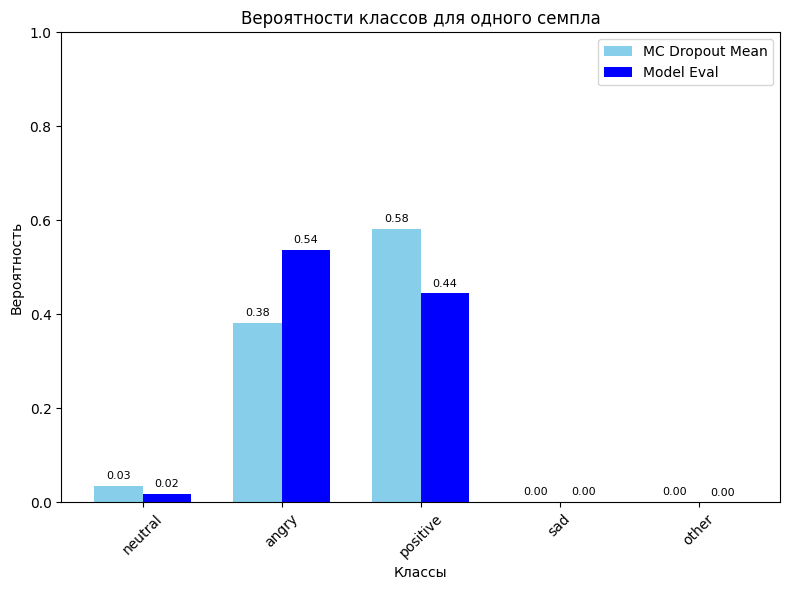

In [62]:
for _ in range(5):
    analyze_aposterior_mean(mc_preds, pred__test_probs)

In [79]:
all_preds.shape

(10, 3601, 5)

In [80]:
mean_preds.shape

(3601, 5)